In [10]:
! pip install langchain-opentutorial
from langchain_opentutorial import package


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [30]:
package.install(
    [
        "langsmith",
        "langgraph",
        "langchain_core",
        "langchain_openai",
    ],
    verbose=False,
    upgrade=False,
)


In [ ]:
# Set environment variables
from langchain_opentutorial import set_env

set_env(
    {
        "OPENAI_API_KEY": "",
        # "LANGCHAIN_API_KEY": "<YOUR_LANGCHAIN_API_KEY>",
       "LANGCHAIN_TRACING_V2": "true",
        "LANGCHAIN_PROJECT": "My-Human-in-the-loop-Test",
    }
)

Environment variables have been set successfully.


In [32]:
! pip install feedparser



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [33]:
import feedparser
from urllib.parse import quote
from typing import List, Dict, Optional
from langchain_core.messages import BaseMessage

In [34]:
# Google News search class
class GoogleNews:
    def __init__(self):
        self.base_url = "https://news.google.com/rss"

    def _fetch_news(self, url: str, k: int = 3) -> List[Dict[str, str]]:
        news_data = feedparser.parse(url)
        return [{"title": entry.title, "link": entry.link} for entry in news_data.entries[:k]]

    def _collect_news(self, news_list: List[Dict[str, str]]) -> List[Dict[str, str]]:
        if not news_list:
            print("No news found.")
            return []
        return [{"url": news["link"], "content": news["title"]} for news in news_list]

    def search_latest(self, k: int = 3) -> List[Dict[str, str]]:
        url = f"{self.base_url}?hl=en&gl=US&ceid=US:en"
        news_list = self._fetch_news(url, k)
        return self._collect_news(news_list)

    def search_by_keyword(self, keyword: Optional[str] = None, k: int = 3) -> List[Dict[str, str]]:
        if keyword:
            encoded_keyword = quote(keyword)
            url = f"{self.base_url}/search?q={encoded_keyword}&hl=en&gl=US&ceid=US:en"
        else:
            url = f"{self.base_url}?hl=en&gl=US&ceid=US:en"
        news_list = self._fetch_news(url, k)
        return self._collect_news(news_list)


In [35]:
# Pretty print LangChain messages
def pretty_print_messages(messages: list[BaseMessage]):
    for message in messages:
        message.pretty_print()

In [36]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

In [37]:
# Define the State for messages
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [38]:
@tool
def search_keyword(query: str) -> List[Dict[str, str]]:
    """
    Search Google News by a given keyword and return top 5 results.
    """
    news_tool = GoogleNews()
    return news_tool.search_by_keyword(query, k=5)

tools = [search_keyword]


In [40]:
# LLM setup
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

In [41]:
# Chatbot node
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

In [42]:
# Tool node
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

# Conditional edge from chatbot to tools
graph_builder.add_conditional_edges("chatbot", tools_condition)

In [43]:
# Define edges
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

# Add MemorySaver
memory = MemorySaver()

# Compile graph
graph = graph_builder.compile(checkpointer=memory)

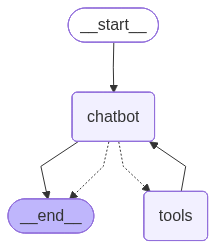

In [44]:
# Visualize graph (optional)
from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [45]:
from langchain_core.runnables import RunnableConfig

# User question
question = "Please provide the latest news related to AI."
input = State(messages=[("user", question)])

config = RunnableConfig(
    recursion_limit=10,
    configurable={"thread_id": "1"},
    tags=["06-LangGraph-Human-in-the-loop"],
)

In [46]:
# Stream events with interruption before tools
for event in graph.stream(
    input=input,
    config=config,
    stream_mode="values",
    interrupt_before=["tools"],
):
    if "messages" in event:
        pretty_print_messages(event["messages"])
        print(f"Number of messages: {len(event['messages'])}")


================================ Human Message =================================

Please provide the latest news related to AI.
Number of messages: 1
================================ Human Message =================================

Please provide the latest news related to AI.
================================== Ai Message ==================================
Tool Calls:
  search_keyword (call_Sau4PeJNv6mHjBcdtXV1xEl0)
 Call ID: call_Sau4PeJNv6mHjBcdtXV1xEl0
  Args:
    query: Artificial Intelligence
Number of messages: 2


In [47]:
# Resume execution from interruption
events = graph.stream(input=None, config=config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  search_keyword (call_Sau4PeJNv6mHjBcdtXV1xEl0)
 Call ID: call_Sau4PeJNv6mHjBcdtXV1xEl0
  Args:
    query: Artificial Intelligence
================================= Tool Message =================================
Name: search_keyword

[{"url": "https://news.google.com/rss/articles/CBMigwFBVV95cUxPblZzY2JVbWVmOFZMU3NOZWNVVi1ONnRBODlFdmEtN2JqeHRvRTBvU3BJTFpTQ3M2azZ0djgxUWNsRWVHVXVFbGlyLWl0U2xzblh4QmljbzIzRXN4T25rekNVNVJ2SlZmX05WYnN1dzlVNzA2OUJYOWhaWU1GZFJSU3NoOA?oc=5", "content": "Analysis | China now leads the U.S. in this key part of the AI race - The Washington Post"}, {"url": "https://news.google.com/rss/articles/CBMikwFBVV95cUxNbzJhYk1vVFpDQ1o1QTF2Y3cxS3ZKSGc1eVZBZzNFQkFWWEk1eXY1aXpZVkJNSlhCSkx0ZTRHQ1NxR2ZxckhyaFA5dkprQXNZcy16bWZaazBKT3ljRG82YWtHM0dkdnRmNWdrQklXVHdPVUNHbmtrcGU5VUdqX1BVUHNySmFnNHpyZEw2dEVKNVBrNHc?oc=5", "content": "3 Millionaire-Maker Artificial Intelligence (AI) Stocks - Yah